<a href="https://colab.research.google.com/github/cshuler/DL_watershed/blob/master/Scripts/Drafts/WS_modeling_V2p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import modules
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
import keras 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from bisect import bisect_left, bisect_right

%matplotlib inline


# provide random seed for reproducible results
np.random.seed(696007)
tf.set_random_seed(696007)

# set options 
pd.set_option('display.max_rows', 30)  

In [41]:
# Clone DL GitHub repo. 
!git clone -l -s git://github.com/cshuler/DL_watershed cloned-repo
# get the cwd to be the folder where this script is located to perserve relative paths
%cd cloned-repo/Scripts    
# note that repo is cloned. Files saved will save to temprary space if in google colab

# create workspace
if not os.path.exists(os.path.join('.', 'workspace')):
    os.makedirs(os.path.join('.', 'workspace'))
workspace = os.path.join('.', 'workspace')

Cloning into 'cloned-repo'...
remote: Enumerating objects: 4454, done.
remote: Counting objects: 100% (4454/4454), done.
remote: Compressing objects: 100% (471/471), done.
remote: Total 4454 (delta 3999), reused 4385 (delta 3950), pack-reused 0
Receiving objects: 100% (4454/4454), 36.80 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (3999/3999), done.
/content/cloned-repo/Scripts/cloned-repo/Scripts


In [0]:
# this is a list of additional functions to load up, as to not clutter the script
%run ../Functions/make_training_dataset
%run ../Functions/find_date_gaps
%run ../Functions/baseflow_separator


### load up data files
(kind of long run time)




In [0]:
# import precip data
preciprawdata = pd.read_csv(os.path.join('..', 'Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Precip_mm.csv' ), index_col=0,parse_dates=True)

# import Temperature data
temprawdata = pd.read_csv(os.path.join('..', 'Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Temp_max_min.csv' ), index_col=0,parse_dates=True)

# import Humidity data
hmdrawdata = pd.read_csv(os.path.join('..', 'Raw_Data_tutuila', 'Olkeba_data', 'WXS_HMD_pct.csv' ), index_col=0,parse_dates=True)

# import Solar rad data
srdrawdata = pd.read_csv(os.path.join('..', 'Raw_Data_tutuila', 'Olkeba_data', 'WXS_SRD_maybe.csv' ), index_col=0,parse_dates=True)

# import Wind data
windrawdata = pd.read_csv(os.path.join('..', 'Raw_Data_tutuila', 'Olkeba_data', 'WXS_Wind.csv' ), index_col=0,parse_dates=True)

#import flow data
LBJflowrawdata = pd.read_csv(os.path.join('..', 'Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Alex_Q_CFSs.csv'), index_col=0, parse_dates=True)
LBJflowrawdata = LBJflowrawdata.resample('D').mean()     # subsample the 15 min data into daily values

# Create merged precip and flow dataframe indexed by date
mergeddata = pd.merge(preciprawdata, LBJflowrawdata, how='inner', left_index=True, right_index=True) 
mergeddata = pd.merge(temprawdata, mergeddata, how='inner', left_index=True, right_index=True) 
mergeddata = pd.merge(hmdrawdata, mergeddata, how='inner', left_index=True, right_index=True) 
mergeddata = pd.merge(srdrawdata, mergeddata, how='inner', left_index=True, right_index=True) 
mergeddata = pd.merge(windrawdata, mergeddata, how='inner', left_index=True, right_index=True) 

# deal with the fact that the beginning and end of the datasets are missing, make them "gaps"
mergeddata['Q_CFS'][0] = mergeddata['Q_CFS'].mean()
mergeddata['Q_CFS'][-1] = mergeddata['Q_CFS'].mean()   # by setting the first and last value to the mean. Super dirty...

unbroken_data = mergeddata.dropna()       # remove any rows where there is no data (a gap)

In [44]:
unbroken_data.columns

Index(['WND_MpS', 'SRD_wpm2', 'HMD_pct', 'Temp_max', 'Temp_min', 'Precip_mm',
       'Q_CFS'],
      dtype='object')

#### format trainng and validation data

In [0]:
# Note this uses a function from the Functions folder

x_cols = ['Precip_mm', 'Temp_max', 'Temp_min', 'HMD_pct' ]       # define variable used for prediction
y_col  = 'Q_CFS'                    # define which variable to predict

X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler =  make_training_dataset(unbroken_data, x_cols, y_col, TS_value=0.90)

In [46]:
# see where there are date gaps using code from Functions folder
where_gaps = find_date_gaps(mergeddata, 'Q_CFS')

gap 0 is 5 days 00:00:00 from 2012-01-02 00:00:00 to 2012-01-07 00:00:00
gap 1 is 6 days 00:00:00 from 2012-04-04 00:00:00 to 2012-04-10 00:00:00
gap 2 is 5 days 00:00:00 from 2012-07-10 00:00:00 to 2012-07-15 00:00:00
gap 3 is 123 days 00:00:00 from 2012-10-11 00:00:00 to 2013-02-11 00:00:00
gap 4 is 137 days 00:00:00 from 2013-09-26 00:00:00 to 2014-02-10 00:00:00
gap 5 is 7 days 00:00:00 from 2014-09-24 00:00:00 to 2014-10-01 00:00:00
gap 6 is 1 days 00:00:00 from 2014-10-09 00:00:00 to 2014-10-10 00:00:00
gap 7 is 230 days 00:00:00 from 2015-06-20 00:00:00 to 2016-02-05 00:00:00
gap 8 is 5 days 00:00:00 from 2016-06-24 00:00:00 to 2016-06-29 00:00:00
gap 9 is 79 days 00:00:00 from 2016-10-13 00:00:00 to 2016-12-31 00:00:00


### Create the DL model, define construction

In [0]:
# Create DLNN model as a function for streamlining code below
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    return model

In [48]:
# DL hyperparameters
hidden_layer_sizes =  [2, 4, 8, 4]
activation     = 'relu'
optimizer      = 'sgd'
input_shape    = len(x_cols)           # this is the number of different variables used for training datasets
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')   # Used for model checkpoint callback, to save best model
keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=150, mode='min', min_delta=0.001),
                      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

# delete any existing model to make sure previous model weights are gone, then remake model again using above function!
model = "reset"; del model                                                          
model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

# run the model
history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

## load the best saved model based on validation loss
model = load_model(checkpoint_path)
scores = model.evaluate(X_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
1106/1106 [==============================] - 0s 107us/step
Score: loss of 0.34690218323178146; mean_squared_error of 34.69

#### Plot results
(note that if prediction dataset is all zeros something wierd happened and need to re-run model)

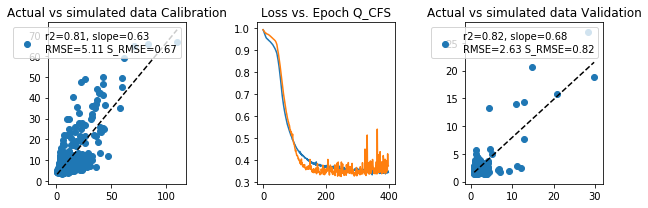

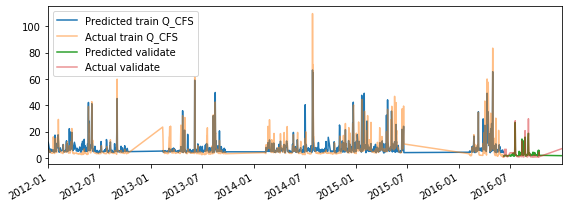

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()
plt.tight_layout()

###### Plot losses
ax[1].set_title('Loss vs. Epoch {}'.format(y_col))
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
plt.tight_layout()

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee
plt.tight_layout()

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()
plt.tight_layout() 

##### time series plot
plt.figure(figsize=(8, 3))
plt.plot(train_data.index, ycal, label='Predicted train {}'.format(y_col))
train_data[y_col].plot(label='Actual train {}'.format(y_col) , alpha = .5)
plt.plot(val_data.index, yval, label='Predicted validate')
val_data[y_col].plot(label='Actual validate', alpha = .5)
plt.legend(loc='best')
plt.tight_layout()

In [0]:
# make the dataset for filling the whole 2005-2016  with the longer datasets 
mergeddata2 = pd.merge(preciprawdata, temprawdata, how='inner', left_index=True, right_index=True) 
mergeddata2 = pd.merge(hmdrawdata, mergeddata2, how='inner', left_index=True, right_index=True) 
mergeddata2 = pd.merge(srdrawdata, mergeddata2, how='inner', left_index=True, right_index=True) 
mergeddata2 = pd.merge(windrawdata, mergeddata2, how='inner', left_index=True, right_index=True) 

bigfill_x_data = mergeddata2[x_cols].values 

# scale the x component of the training data
X_bigfill_scaler = StandardScaler().fit(bigfill_x_data)
bigfill_x_data = X_bigfill_scaler.transform(bigfill_x_data)  

## Apply the DL model to the large Precip dataset to create modeled streamflow data

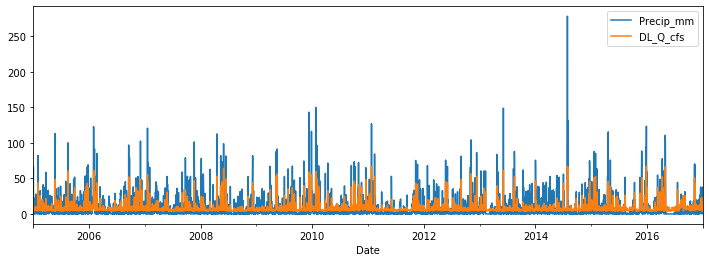

In [51]:

## now model streamflow for the whole period where we have precip data
y_pred_fill = model.predict(np.squeeze(bigfill_x_data))
y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above 

Magicdata = preciprawdata.copy()
Magicdata['DL_Q_cfs'] = y_pred_fill

Magicdata.plot(figsize = (12,4))

del Magicdata.index.name   # baseflow separator wont work without this

In [52]:
# calculate streamflow stats on each tineseries

MF_mean = Magicdata['DL_Q_cfs'].mean()
MF_mean_pcterr  = abs((LBJflowrawdata.mean().values[0] - MF_mean) / LBJflowrawdata.mean().values[0])
print("actual flow mean is {:.2f}, magic flow mean is {:.2f} CFS, %err = {:.2f}".format(LBJflowrawdata.mean().values[0], MF_mean, MF_mean_pcterr))

MF_med = Magicdata['DL_Q_cfs'].median()
MF_med_pcterr  = abs((LBJflowrawdata.median().values[0] - MF_med) / LBJflowrawdata.median().values[0])
print("actual flow median is {:.2f}, magic flow median is {:.2f} CFS, %err = {:.2f}".format(LBJflowrawdata.median().values[0], MF_med, MF_med_pcterr))

All_flows_real, RO_mean_real, BF_mean_real, TF_mean_real = baseflow_separator(LBJflowrawdata.index, LBJflowrawdata['Q_CFS'])
All_flows_magic, RO_mean_magic, BF_mean_magic, TF_mean_magic = baseflow_separator(Magicdata.index, Magicdata['DL_Q_cfs'])

BF_mean_pcterr = abs((BF_mean_real -  BF_mean_magic)/BF_mean_real)
RO_mean_pcterr = abs((RO_mean_real - RO_mean_magic)/RO_mean_real)

print("actual flow BF is {:.2f}, magic flow BF is {:.2f} CFS, %err = {:.2f}".format(BF_mean_real, BF_mean_magic, BF_mean_pcterr))
print("actual flow RO is {:.2f}, magic flow RO is {:.2f} CFS, %err = {:.2f}".format(RO_mean_real, RO_mean_magic, RO_mean_pcterr))

# Calculate exceedednce values
Desired_Q_exceed_value = .90

data = Magicdata['DL_Q_cfs'].to_numpy()
sort = np.sort(data)[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)
excedenceframe = pd.DataFrame(data=sort, index=exceedence, columns=['flow'])
idx = bisect_left(excedenceframe.index, Desired_Q_exceed_value)
Magic_sceed_flow = excedenceframe["flow"].iloc[idx]

LBJflowrawdata = LBJflowrawdata.dropna() # need to drop nan rows first
data = LBJflowrawdata['Q_CFS'].to_numpy()
sort = np.sort(data)[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)
excedenceframe = pd.DataFrame(data=sort, index=exceedence, columns=['flow'])
idx = bisect_left(excedenceframe.index, Desired_Q_exceed_value)
real_sceed_flow = excedenceframe["flow"].iloc[idx]

Q_pcterr = abs((real_sceed_flow - Magic_sceed_flow)/real_sceed_flow)
print('The Q_{} value is {:.2f} for real data and {:.2f} for magic data, %err = {:.2f}'.format(Desired_Q_exceed_value, real_sceed_flow, Magic_sceed_flow, Q_pcterr))
print("........................................")

avepcterridx = np.array([MF_mean_pcterr, MF_med_pcterr, BF_mean_pcterr, RO_mean_pcterr, Q_pcterr ]).mean()
print("Ave %err index = {:.4f}".format(avepcterridx))



actual flow mean is 7.02, magic flow mean is 7.81 CFS, %err = 0.11
actual flow median is 4.26, magic flow median is 5.60 CFS, %err = 0.31
actual flow BF is 3.18, magic flow BF is 4.62 CFS, %err = 0.45
actual flow RO is 3.72, magic flow RO is 3.20 CFS, %err = 0.14
The Q_0.9 value is 2.52 for real data and 4.44 for magic data, %err = 0.76
........................................
Ave %err index = 0.3569


# comparison between magic flows with different datasets

**x_cols = ['Precip_mm', 'Temp_max', 'Temp_min', 'SRD_wpm2', 'HMD_pct' ]**
- actual flow mean is 7.02, magic flow mean is 7.76 CFS, %err = 0.11
- actual flow median is 4.26, magic flow median is 5.52 CFS, %err = 0.30
- actual flow BF is 3.30, magic flow BF is 5.53 CFS, %err = 0.67
- actual flow RO is 3.74, magic flow RO is 2.22 CFS, %err = 0.41
- The Q_0.9 value is 2.52 for real data and 5.52 for magic data, %err = 1.19
........................................
- Ave %err index = 0.5352

**x_cols = ['Precip_mm', 'Temp_max', 'Temp_min', 'HMD_pct' ]**
- actual flow mean is 7.02, magic flow mean is 7.41 CFS, %err = 0.06
- actual flow median is 4.26, magic flow median is 5.33 CFS, %err = 0.25
- actual flow BF is 3.30, magic flow BF is 4.24 CFS, %err = 0.28
- actual flow RO is 3.74, magic flow RO is 3.17 CFS, %err = 0.15
- The Q_0.9 value is 2.52 for real data and 4.01 for magic data, %err = 0.60
........................................
- Ave %err index = 0.2674

**REPRODUCE x_cols = ['Precip_mm', 'Temp_max', 'Temp_min', 'HMD_pct' ]**
- actual flow mean is 7.02, magic flow mean is 7.49 CFS, %err = 0.07
- actual flow median is 4.26, magic flow median is 5.89 CFS, %err = 0.38
- actual flow BF is 3.30, magic flow BF is 4.62 CFS, %err = 0.40
- actual flow RO is 3.74, magic flow RO is 2.88 CFS, %err = 0.23
- The Q_0.9 value is 2.52 for real data and 4.33 for magic data, %err = 0.72
........................................
- Ave %err index = 0.3604

**REPRODUCE2 x_cols = ['Precip_mm', 'Temp_max', 'Temp_min', 'HMD_pct' ]**

- actual flow mean is 7.02, magic flow mean is 7.60 CFS, %err = 0.08
- actual flow median is 4.26, magic flow median is 4.71 CFS, %err = 0.11
- actual flow BF is 3.30, magic flow BF is 4.68 CFS, %err = 0.42
- actual flow RO is 3.74, magic flow RO is 2.92 CFS, %err = 0.22
- The Q_0.9 value is 2.52 for real data and 4.62 for magic data, %err = 0.84
........................................
- Ave %err index = 0.3326


**x_cols = ['Precip_mm', 'Temp_max', 'Temp_min' ]**
- actual flow mean is 7.02, magic flow mean is 7.78 CFS, %err = 0.11
- actual flow median is 4.26, magic flow median is 5.44 CFS, %err = 0.28
- actual flow BF is 3.30, magic flow BF is 5.45 CFS, %err = 0.65
- actual flow RO is 3.74, magic flow RO is 2.32 CFS, %err = 0.38
- The Q_0.9 value is 2.52 for real data and 5.43 for magic data, %err = 1.16
........................................
- Ave %err index = 0.5145

**x_cols = ['Precip_mm', 'Temp_max',  ]**
- actual flow mean is 7.02, magic flow mean is 7.53 CFS, %err = 0.07
- actual flow median is 4.26, magic flow median is 5.00 CFS, %err = 0.18
- actual flow BF is 3.30, magic flow BF is 4.99 CFS, %err = 0.51
- actual flow RO is 3.74, magic flow RO is 2.53 CFS, %err = 0.32
- The Q_0.9 value is 2.52 for real data and 4.96 for magic data, %err = 0.97
........................................
- Ave %err index = 0.4104

**Only precip**
- actual flow mean is 7.02, magic flow mean is 7.14 CFS, %err = 0.02
- actual flow median is 4.26, magic flow median is 4.97 CFS, %err = 0.17
- actual flow BF is 3.18, magic flow BF is 4.62 CFS, %err = 0.45
- actual flow RO is 3.72, magic flow RO is 2.52 CFS, %err = 0.32
- The Q_0.9 value is 2.52 for real data and 4.55 for magic data, %err = 0.81
........................................
- Ave %err index = 0.3535

**Reproduce precip only 1**
- actual flow mean is 7.02, magic flow mean is 7.25 CFS, %err = 0.03
- actual flow median is 4.26, magic flow median is 4.80 CFS, %err = 0.13
- actual flow BF is 3.30, magic flow BF is 4.80 CFS, %err = 0.45
- actual flow RO is 3.74, magic flow RO is 2.45 CFS, %err = 0.35
- The Q_0.9 value is 2.52 for real data and 4.80 for magic data, %err = 0.91
........................................
- Ave %err index = 0.3732

**Reproduce precip only 2**
- actual flow mean is 7.02, magic flow mean is 7.37 CFS, %err = 0.05
- actual flow median is 4.26, magic flow median is 4.72 CFS, %err = 0.11
- actual flow BF is 3.30, magic flow BF is 4.69 CFS, %err = 0.42
- actual flow RO is 3.74, magic flow RO is 2.68 CFS, %err = 0.28
- The Q_0.9 value is 2.52 for real data and 4.67 for magic data, %err = 0.86
........................................
- Ave %err index = 0.3441

**Reproduce precip only 3**
- actual flow mean is 7.02, magic flow mean is 7.46 CFS, %err = 0.06
- actual flow median is 4.26, magic flow median is 5.06 CFS, %err = 0.19
- actual flow BF is 3.30, magic flow BF is 5.01 CFS, %err = 0.52
- actual flow RO is 3.74, magic flow RO is 2.45 CFS, %err = 0.34
- The Q_0.9 value is 2.52 for real data and 4.99 for magic data, %err = 0.98
........................................
- Ave %err index = 0.4195

**Reproduce precip only 3**
- actual flow mean is 7.02, magic flow mean is 7.46 CFS, %err = 0.06
- actual flow median is 4.26, magic flow median is 5.06 CFS, %err = 0.19
- actual flow BF is 3.30, magic flow BF is 5.01 CFS, %err = 0.52
- actual flow RO is 3.74, magic flow RO is 2.45 CFS, %err = 0.34
- The Q_0.9 value is 2.52 for real data and 4.99 for magic data, %err = 0.98
........................................
- Ave %err index = 0.4195


**ALL 6 variables ['Precip_mm', 'Temp_max', 'Temp_min', 'SRD_wpm2', 'HMD_pct', 'WND_MpS' ]**
- actual flow mean is 7.02, magic flow mean is 7.78 CFS, %err = 0.11
- actual flow median is 4.26, magic flow median is 5.04 CFS, %err = 0.18
- actual flow BF is 3.18, magic flow BF is 5.10 CFS, %err = 0.60
- actual flow RO is 3.72, magic flow RO is 2.69 CFS, %err = 0.28
- The Q_0.9 value is 2.52 for real data and 5.04 for magic data, %err = 1.00
........................................
- Ave %err index = 0.4357

**x_cols1 = ['Precip_mm', 'Temp_max', 'Temp_min', 'SRD_wpm2', 'HMD_pct', 'WND_MpS' ]**
- actual flow mean is 7.02, magic flow mean is 7.74 CFS, %err = 0.10
- actual flow median is 4.26, magic flow median is 5.01 CFS, %err = 0.18
- actual flow BF is 3.30, magic flow BF is 4.93 CFS, %err = 0.49
- actual flow RO is 3.74, magic flow RO is 2.81 CFS, %err = 0.25
- The Q_0.9 value is 2.52 for real data and 4.88 for magic data, %err = 0.94
........................................
- Ave %err index = 0.3918


**x_cols2 = ['Precip_mm', 'Temp_max', 'Temp_min', 'SRD_wpm2', 'HMD_pct', 'WND_MpS' ]**
- actual flow mean is 7.02, magic flow mean is 7.41 CFS, %err = 0.06
- actual flow median is 4.26, magic flow median is 5.51 CFS, %err = 0.29
- actual flow BF is 3.30, magic flow BF is 4.68 CFS, %err = 0.42
- actual flow RO is 3.74, magic flow RO is 2.74 CFS, %err = 0.27
- The Q_0.9 value is 2.52 for real data and 4.68 for magic data, %err = 0.86
........................................
- Ave %err index = 0.3784

**x_cols2 = ['Precip_mm', 'Temp_max', 'Temp_min', 'SRD_wpm2', 'HMD_pct', 'WND_MpS' ]**
- actual flow mean is 7.02, magic flow mean is 7.98 CFS, %err = 0.14
- actual flow median is 4.26, magic flow median is 5.69 CFS, %err = 0.34
- actual flow BF is 3.30, magic flow BF is 4.96 CFS, %err = 0.50
- actual flow RO is 3.74, magic flow RO is 3.03 CFS, %err = 0.19
- The Q_0.9 value is 2.52 for real data and 4.79 for magic data, %err = 0.90
........................................
- Ave %err index = 0.4132



**This represnets flat line mean value (from model failure) **
- actual flow mean is 7.02, magic flow mean is 7.45 CFS, %err = 0.06
- actual flow median is 4.26, magic flow median is 7.45 CFS, %err = 0.75
- actual flow BF is 3.30, magic flow BF is 7.45 CFS, %err = 1.25
- actual flow RO is 3.74, magic flow RO is 0.00 CFS, %err = 1.00
- The Q_0.9 value is 2.52 for real data and 7.45 for magic data, %err = 1.96
........................................
- Ave %err index = 1.0053

# And now for something completely different....  Using CNN to work on the same problem 

In [0]:
from tensorflow.keras.models import Sequential # layer-by-layer construction
from tensorflow.keras.layers import Dense # dense: fully connected layers
from tensorflow.nn import relu, sigmoid, elu # activation functions
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
from tensorflow.keras.layers import Flatten, Dropout
import tensorflow as tf


# provide random seed for reproducible results
np.random.seed(696007)
tf.set_random_seed(696007)

In [0]:
# cut this up to make it a round number
unbroken_data2 = unbroken_data.iloc[0:1200]

x_cols = ['Precip_mm', 'Temp_max', 'Temp_min', 'SRD_wpm2', 'HMD_pct', 'WND_MpS' ]           # define variable used for prediction
y_col  = 'Q_CFS'                    # define which variable to predict

X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler =  make_training_dataset(unbroken_data2, x_cols, y_col, TS_value=(1000/1200))

In [0]:
# set up some numbers for looping and batch size  (note batches*TS has to add up to dataset length)

batchs    = 5
TS        = 200
channels  = len(x_cols)

# Calibration (training) data 

In [0]:
# format the input data for the partucilar batch sample, timesteo size
X = X_train.squeeze()
y = y_train.squeeze()

y1 = np.array(y).reshape(batchs, TS)       # Output size [num of batches, timesteps]
x1 = np.array(X).reshape(batchs, TS, channels)    # the 1 here referst to the number of variabls to use increase if more channels # Input size [num batches, TS, channels]

# here use the entire dataset as the sample size with 1000 time steps as the training dataset
model1 = tf.keras.Sequential()
model1.add(Conv1D(filters = 8, kernel_size = 5, activation = 'relu', input_shape = (TS,channels)))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size = 2))
model1.add(Conv1D(filters =8, kernel_size = 5, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size = 2))
model1.add(Flatten())
model1.add(Dense(96, activation = 'sigmoid'))
model1.add(Dense(24, activation = 'elu'))
model1.add(Dense(TS)) # <= here I changed from 1 to N= 6152
model1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

print(model1.summary())
model1.fit(x1, y1, epochs = 400, batch_size = 32, verbose = 1)
	
# evaluate model
_, accuracy = model1.evaluate(x1, y1, batch_size = 12, verbose = 1)

In [33]:
y_train_pred2 = model1.predict(x1)   # run the model preditcion on the training data itself   

###### Plot losses and scatter
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].set_title('Loss vs. Epoch {}'.format(y_col))   
ax[0].plot(history.history['loss'])    # losses
plt.tight_layout()


# scatter
for i in range(batchs):
  real_y = np.squeeze(y1[i])
  pred_y = np.squeeze(y_train_pred2[i])
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, pred_y)                              # get stats on regression
  mea = np.mean(np.abs(real_y-pred_y))
  rmse = np.sqrt(np.mean(np.abs(real_y-pred_y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
  Std_RMSE = rmse/((np.mean(real_y)+np.mean(pred_y))/2)                                 # standardize the RMSE as a % of the mean
  #ax[1].plot(np.unique(real_y), np.poly1d(np.polyfit(real_y, pred_y, 1))(np.unique(real_y)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
  ax[1].scatter(real_y, pred_y, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
  ax[1].set_title('Actual vs simulated data Calibration')
  #ax[1].legend()
  plt.tight_layout()

##### time series plot
plt.figure(figsize=(15, 3))
plt.plot(range(0,TS*batchs),  np.squeeze(y), label='real flow', alpha = 1, color='k')   # plot the real (training) data

for i in range(batchs):
  plt.plot(range(i*200,(i+1)*200),  np.squeeze(y_train_pred2[i]), label='Predicted flow', alpha = .6)   # plot the predicted data from each of the training batches

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SO, this is broken
need to look into how to unscale y data before comparison. Make sure this is hjappening on the regular network above and need to fix on RNN below. 



# Validata set (last 200 observations)



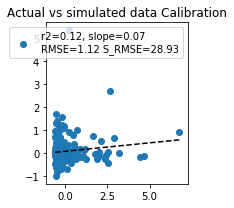

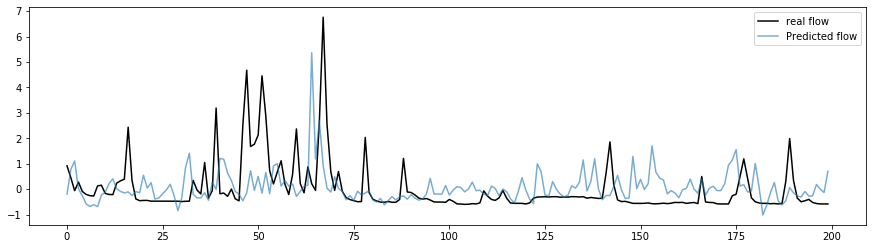

In [37]:
# work on generating a validataion dataset
X_val_conv = X_val.squeeze()
x_val_conv1 = np.array(X_val_conv).reshape(1,X_val_conv.shape[0], channels)    
y_val_conv = y_val.squeeze()

y_val_pred2 = model1.predict(x_val_conv1)   # run the model preditcion on the validataion data

###### Plot scatter
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
real_y = np.squeeze(y_val_conv)
pred_y = np.squeeze(y_val_pred2)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, pred_y)                              # get stats on regression
mea = np.mean(np.abs(real_y-pred_y))
rmse = np.sqrt(np.mean(np.abs(real_y-pred_y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(real_y)+np.mean(pred_y))/2)                                 # standardize the RMSE as a % of the mean
ax.plot(np.unique(real_y), np.poly1d(np.polyfit(real_y, pred_y, 1))(np.unique(real_y)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax.scatter(real_y, pred_y, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax.set_title('Actual vs simulated data Calibration')
ax.legend()
plt.tight_layout()

##### time series plot
plt.figure(figsize=(15, 4))
plt.plot(range(0, TS),  np.squeeze(y_val_conv), label='real flow', alpha = 1, color='k')   # plot the real (training) data
plt.plot(range(0, TS),  np.squeeze(y_val_pred2), label='Predicted flow', alpha = .6)   # plot the predicted data from each of the training batches

plt.legend(loc='best')


In [38]:
list(y_val_pred2) #, y_val_pred2

[array([-1.88530445e-01,  7.79772818e-01,  1.10865140e+00,  2.01163925e-02,
        -2.55143344e-01, -5.71670234e-01, -6.75067604e-01, -6.06927812e-01,
        -6.80862129e-01, -2.28219464e-01, -1.12505093e-01,  2.27373153e-01,
         4.08652633e-01,  1.71621963e-02, -8.40868652e-02, -1.45018771e-01,
        -9.99066383e-02, -2.46418878e-01, -9.09692049e-02, -1.38872474e-01,
         5.54082632e-01,  4.61194739e-02,  2.61105299e-01, -3.81714582e-01,
        -3.45768511e-01, -1.76640585e-01, -2.30720006e-02,  1.95708811e-01,
        -2.46463209e-01, -8.41850579e-01, -3.50790113e-01,  8.56550515e-01,
         1.41496205e+00, -1.96057037e-01, -3.37904423e-01, -3.36012661e-01,
        -1.32540897e-01, -4.32243347e-01,  2.71777302e-01, -7.26522505e-03,
         1.20908189e+00,  1.17755938e+00,  6.40021026e-01,  3.41378778e-01,
        -8.46749470e-02, -1.93192855e-01, -4.53538507e-01, -1.40562832e-01,
         7.28659868e-01, -4.46949005e-02,  5.04932702e-01, -1.51540712e-01,
         6.5

In [28]:
list(y_val)

[array([0.9213066]),
 array([0.45816121]),
 array([-0.05482386]),
 array([0.28207843]),
 array([-0.08359762]),
 array([-0.20345018]),
 array([-0.25195079]),
 array([-0.26526532]),
 array([0.1324723]),
 array([0.15870944]),
 array([-0.16261387]),
 array([-0.20457152]),
 array([-0.2100258]),
 array([0.24217838]),
 array([0.331929]),
 array([0.39519207]),
 array([2.43687702]),
 array([0.34785635]),
 array([-0.37971804]),
 array([-0.44847894]),
 array([-0.43823448]),
 array([-0.43796231]),
 array([-0.46661632]),
 array([-0.46692115]),
 array([-0.4664639]),
 array([-0.46738928]),
 array([-0.46676873]),
 array([-0.46533168]),
 array([-0.46771588]),
 array([-0.46885899]),
 array([-0.48224973]),
 array([-0.47212503]),
 array([-0.46722598]),
 array([0.34788901]),
 array([-0.0281077]),
 array([-0.18286328]),
 array([1.05196974]),
 array([-0.34759115]),
 array([-0.05229813]),
 array([3.19080608]),
 array([-0.17700619]),
 array([-0.14822155]),
 array([-0.27693595]),
 array([0.00909242]),
 array([-